In [3]:
import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

from solver import Instance, Solver
from argparse import Namespace
from gurobipy import Model, GRB, tupledict
import gurobipy as gp
import json

import time
from tqdm import tqdm
import ast

In [4]:
read_instance_file = True
city = "berlin"

In [5]:
if read_instance_file:
    demand_baseline = "1.00"
    demand_type = "uniform"
    
    demand_file = f'{city}_db={demand_baseline}_dt={demand_type}.csv'
    print(demand_file)

    demand_df = pd.read_csv(demand_file, index_col=0)
    demand_df['area_id'] = demand_df['area_id'].astype(str) 
    days_ = []
    for i in range(7):
        days_.append([i, "1.00", "uniform"])
    days = pd.DataFrame(days_, columns=['day', 'demand_baseline', 'demand_type']) 
else:
    # Generate instance file
    # Generate several days instances 
    days = pd.DataFrame([
        [0, "1.00", "uniform"], # Monday
        [1, "1.00", "uniform"], # Tuesday
        [2, "1.00", "uniform"], # Wednesday
        [3, "1.00", "uniform"], # Thursday
        [4, "1.00", "uniform"], # Friday
        [5, "1.00", "uniform"], # Satuday
        [6, "1.00", "uniform"], # Sunday
    ], columns=['day', 'demand_baseline', 'demand_type']
    )

    demand = []
    area_region_map = None

    for i, row in days.iterrows():
        demand_baseline, demand_type = row['demand_baseline'], row['demand_type']
        key = f'{city}_db={demand_baseline}_dt={demand_type}'

        instance_file = f'../instances/{city}_db={demand_baseline}_dt={demand_type}.json'
        with open(instance_file, 'r') as file:
            instance_data = json.load(file)

        if area_region_map is None:
            regions = instance_data['geography']['city']['regions']
            area_region_map = {}
            for region in regions:
                areas = region['areas'] 
                for area in areas:
                    area_region_map[area['id']] = region['id']
        
        scenario = random.randint(0, instance_data['num_scenarios']-1)
        data_ = (
            pd.DataFrame(instance_data['scenarios'][scenario]['data'])
            .assign(
                day = row['day']
            )
        )
        demand.append(data_)

    demand_df = pd.concat(demand)
    # Add region
    demand_df['region_id'] = demand_df['area_id'].map(area_region_map)

    demand_df = demand_df[['day', 'region_id', 'area_id', 'demand', 'required_couriers']]
    #demand_df.to_csv(f'{city}_db={demand_baseline}_dt={demand_type}.csv')

display(demand_df.head(20))

berlin_db=1.00_dt=uniform.csv


,day,region_id,area_id,demand,required_couriers
0,0,1,10115,"[0, 2, 2, 4, 1, 4, 7, 2]","[0, 1, 1, 1, 1, 1, 2, 1]"
1,0,1,10117,"[4, 3, 1, 1, 2, 2, 2, 3]","[1, 1, 1, 1, 1, 1, 1, 1]"
2,0,1,10119,"[0, 2, 0, 0, 2, 2, 6, 4]","[0, 1, 0, 0, 1, 1, 2, 1]"
3,0,1,10178,"[3, 1, 2, 0, 4, 2, 0, 0]","[1, 1, 1, 0, 1, 1, 0, 0]"
4,0,1,10179,"[3, 1, 3, 2, 1, 5, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1]"
5,0,2,10243,"[4, 4, 2, 2, 3, 2, 1, 3]","[1, 1, 1, 1, 1, 1, 1, 1]"
6,0,0,10245,"[3, 2, 3, 5, 2, 1, 1, 2]","[1, 1, 1, 1, 1, 1, 1, 1]"
7,0,0,10247,"[4, 4, 8, 7, 3, 4, 7, 4]","[1, 1, 2, 2, 1, 1, 2, 1]"
8,0,0,10249,"[4, 4, 1, 5, 2, 1, 3, 5]","[1, 1, 1, 1, 1, 1, 1, 1]"
9,0,0,10315,"[4, 8, 4, 1, 3, 5, 2, 5]","[1, 2, 1, 1, 1, 1, 1, 1]"


In [6]:
outsourcing_cost_multiplier = 1.5
region = 0

In [7]:
# PARAMETERS
# Regions
R = sorted([region])

region_area_map = {}
for r in R:
    for a in list(demand_df.query(f'region_id == {r}')['area_id'].unique()):
        region_area_map[a] = r
        
# Areas 
A = {}
area_map = {a: i for i, a in enumerate(list(demand_df['area_id'].unique())) }
areas = list(area_map.keys())
n_areas = len(areas)
for r in R:
    A[r] = [ area_map[a] for a in list(demand_df.query(f'region_id == {r}')['area_id'].unique()) ]
 
# Set of all shifts available
P = {}
n_shifts = 2
shifts = [s for s in range(n_shifts)]
for r in R:
    P[r] = shifts

# Shifts start and end times
shifts_start = {0: 0, 1:2}
shifts_end = {0: 4, 1:6}

# Periods
n_periods = 8
Theta = [i for i in range(n_periods)]

# Days
n_days = 7
D = [d for d in range(n_days)]

# Set of demand scenarios
# TODO

# Hours in shift
h = {}
n_hours = 8
for p in range(n_shifts):
    h[p] = n_hours

# Cost outsource
c_out = outsourcing_cost_multiplier

# Number of deliveries to perform (n_{a theta d})
deliveries = np.zeros((n_areas, n_periods, n_days))
for i, a in enumerate(areas):
    for k, d in enumerate(D):
        period_demands = demand_df.query(f'area_id == "{a}" & day == {d}')
        deliveries[i, :, k] = ast.literal_eval(period_demands['demand'].values[0])

# Number of couriers needed (m_{a theta d})
couriers_needed = np.zeros((n_areas, n_periods, n_days))
for i, a in enumerate(areas):
    for k, d in enumerate(D):
        period_demands = demand_df.query(f'area_id == "{a}" & day == {d}')
        couriers_needed[i, :, k] = ast.literal_eval(period_demands['required_couriers'].values[0])

# Cost of employed courier (c_{a theta d})
cost_couriers = np.zeros((n_areas, n_periods, n_days))
cost_courier = 1
for i, a in enumerate(areas):
    for j, t in enumerate(Theta):
        for k, d in enumerate(D):
            cost_couriers[i, j, k] = cost_courier

# mega_value
M = 999_999

# No logs
env = gp.Env(empty=True)
env.setParam("OutputFlag",0)
env.start()
m = gp.Model("mip1", env=env)

In [8]:
results = []

In [9]:
# Employees (we will iterate)
min_obj_value = float('inf')

for n_employees in tqdm(range(10, 30)):
    start = time.time()

    E = {}
    for r in R:
        E[r] = [i for i in range(n_employees)]

    employees = [e for e in range(n_employees)]

    # Min hours worked for employee e
    min_hours_worked = 8*6
    h_min = {e: min_hours_worked for e in employees}

    # Max hours worked for employee e
    max_hours_worked = 8*6
    h_max = {e: max_hours_worked for e in employees}

    # Max differing starts
    max_unique_starts = 2
    b_max = {e: max_unique_starts for e in employees}

    # DECISION VARIABLES
    m = Model()

    # r_{e p d}
    r_var = m.addVars(n_employees, n_shifts, n_days, vtype=GRB.BINARY, name='r')

    # k_{e a theta d}
    k_var = m.addVars(n_employees, n_areas, n_periods, n_days, vtype=GRB.BINARY, name='k')

    # U_{e p}
    u_var = m.addVars(n_employees, n_shifts, vtype=GRB.BINARY, name='u')

    # omega_{a theta d}
    omega_var = m.addVars(n_areas, n_periods, n_days, vtype=GRB.CONTINUOUS, lb=0, name='omega')

    # 1. Connecting employees moving around areas to shift assignment p
    for r in R:
        for e in E[r]:
            for d in D:
                Ar, Pr = A[r], P[r]
                m.addConstr(
                    (sum([k_var[e, a, theta, d] for a in Ar for theta in Theta]) == 1/2 * sum([h[p] * r_var[e,p,d] for p in Pr])),
                    name = f'moving_areas_{r}_{e}_{d}'          
                )

    # 2. Employee can only be assigned to one area at a time 
    for r in R:
        for e in E[r]:
            for theta in Theta:
                for d in D:
                    Ar = A[r]
                    m.addConstr((sum([k_var[e, a, theta, d] for a in Ar]) <= 1),
                        name = f'employee_{r}_{e}_{theta}_{d}'          
                    )

    # ADDED - Shift start and end times
    for shift in shifts:
        start = shifts_start[shift]
        for theta in Theta[:start]:
            for e in employees:
                for a in areas:
                    for d in D:
                        m.addConstr((k_var[e, area_map[a], theta, d] * r_var[e, shift, d] == 0),
                            name = f'start_time_{e}_{a}_{shift}_{d}'          
                        )

    for shift in shifts:
        end = shifts_end[shift]
        for theta in Theta[end:]:
            for e in employees:
                for a in areas:
                    for d in D:
                        m.addConstr((k_var[e, area_map[a], theta, d] * r_var[e, shift, d] == 0),
                            name = f'end_time_{e}_{a}_{shift}_{d}'          
                        )

    # 3. Employee can only work one shift a day
    for r in R:
        for es in E[r]:
            for d in D:
                Pr = P[r]
                m.addConstr((sum([r_var[e, p, d] for p in Pr]) <= 1),
                    name = f'only_one_shift_{r}_{e}_{theta}_{d}'          
                )

    # 4. One rest day a week
    for r in R:
        for e in E[r]:
            Pr = P[r]
            m.addConstr((sum([r_var[e, p, d] for p in Pr for d in D]) <= 6),
                name = f'rest_day_{r}_{e}'          
            )

    # 5. Min - Max hours worked per week
    for r in R:
        Pr = P[r]
        for e in E[r]:
            min_hours = h_min[e]
            max_hours = h_max[e]

            m.addConstr((sum([ h[p] * r_var[e, p, d] for p in Pr for d in D]) >= min_hours),
                name = f'min_hours_{r}_{e}'          
            )

            m.addConstr(( sum([ h[p] * r_var[e, p, d] for p in Pr for d in D]) <= max_hours),
                name = f'max_hours_{r}_{e}'          
            )

    # 6. Different shifting times constraint
    for r in R:
        for e in E[r]:
            for p in P[r]:
                m.addConstr((sum([r_var[e, p, d] for d in D]) <= u_var[e, p] * M),
                    name = f'start_times_{r}_{e}_1'          
                )

    for r in R:
        for e in E[r]:
            Pr = P[r]
            m.addConstr((sum([u_var[e, p] for p in Pr]) <= b_max[e]),
                name = f'start_times_{r}_{e}_2'          
            )

    # 7. Employee can't work then outsource
    for r in R:
        for a in A[r]:
            for theta in Theta:
                for d in D:
                    # Be careful with parantheses!!
                    if couriers_needed[a,theta,d] > 0:
                        factor = deliveries[a, theta, d] / couriers_needed[a, theta, d] * c_out 
                    else:
                        factor = 0
                    m.addConstr(
                        ((couriers_needed[a, theta, d] - sum([k_var[e, a, theta, d] for e in E[r]])) * factor <= omega_var[a, theta, d]),
                        name = f'outsource_{r}_{a}_{theta}_{d}'   
                    )

    m.setObjective(
        sum([
            sum([cost_couriers[a, theta, d] * k_var[e, a, theta, d] for e in E[r]]) 
                + omega_var[a, theta, d]
        for r in R for a in A[r] for theta in Theta for d in D] #+ n_employees
        )
    )
    m.setParam('OutputFlag', 0) # No logs 
    m.ModelSense = GRB.MINIMIZE
    m.optimize()
    
    hiring = sum([ sum([cost_couriers[a, theta, d] * k_var[e, a, theta, d].X for e in E[r]]) 
        for r in R for a in A[r] for theta in Theta for d in D])
    
    outsourcing = sum([omega_var[a, theta, d].X for r in R for a in A[r] for theta in Theta for d in D])
    obj_value = m.ObjVal

    exec_time = time.time() - start

    # Check the optimization status
    status = m.status

    # Determine feasibility based on the optimization status
    if status == GRB.Status.INFEASIBLE:
        obj_value, hiring, outsourcing = np.nan, np.nan, np.nan

    results.append({'n_employees': n_employees, 'obj_value': obj_value, 
                    'hiring_costs': hiring, 'outsourcing_costs': outsourcing, 'exec_time': exec_time})
    
    if status == GRB.Status.INFEASIBLE:
        break

  0%|          | 0/20 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-12


100%|██████████| 20/20 [12:30<00:00, 37.53s/it] 


In [10]:
results_df = pd.DataFrame(results)
results_df = (
    results_df 
    .assign(
        obj_value = results_df['obj_value'].apply(lambda x: np.round(x, 1))
    )
)
results_df

,n_employees,obj_value,hiring_costs,outsourcing_costs,exec_time
0,10,1424.2,240.0,1184.25,1.715266e+09
1,11,1369.5,264.0,1105.50,1.715266e+09
2,12,1323.0,288.0,1035.00,1.715266e+09
3,13,1288.5,312.0,976.50,1.715266e+09
4,14,1263.0,336.0,927.00,1.715266e+09
5,15,1242.0,360.0,882.00,1.715266e+09
6,16,1221.0,384.0,837.00,1.715266e+09
7,17,1206.0,408.0,798.00,1.715266e+09
8,18,1194.0,432.0,762.00,1.715266e+09
9,19,1182.0,456.0,726.00,1.715266e+09


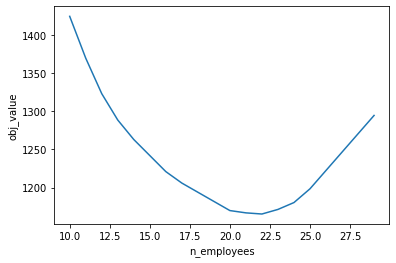

In [11]:
sns.lineplot(data=results_df, x='n_employees', y='obj_value')
plt.show()

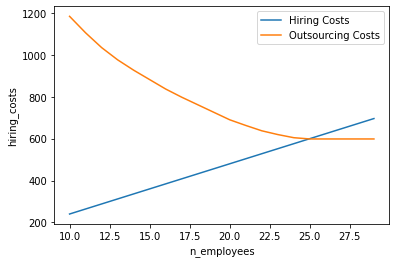

In [14]:
sns.lineplot(data=results_df, x='n_employees', y='hiring_costs', label='Hiring Costs')
sns.lineplot(data=results_df, x='n_employees', y='outsourcing_costs', label='Outsourcing Costs')
plt.show()